In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


# Dataframes formation

In [13]:
datasets = ['Salinas', 'Indian Pines', 'Pavia Centre', 'Pavia University']

data_pca = {'Initial nº principal components': [6, 69, 14, 16],
            'Final nº principal components': [6, 64, 9, 11]}
df_pca = pd.DataFrame(data_pca, index=datasets)

data_bands = {'Initial nº of bands before PCA': [224, 220, 102, 103],
              'Final nº of bands before PCA': [182, 200, 81, 62]}
df_bands = pd.DataFrame(data_bands, index=datasets)

data_acc = {'Initial accuracy (all bands)': [0.889543, 0.720710, 0.892378, 0.837373],
            'Final accuracy': [0.895174, 0.729007, 0.898099, 0.856461]}
df_acc = pd.DataFrame(data_acc, index=datasets)

data_times = {'Duration': [4229.799, 1862.727, 2727.677, 1470.671],
                }

df_times = pd.DataFrame(data_times, index=datasets)

data_misc = {'Spatial resolution (meters)': [3.7, 20, 1.3, 1.3],
             'Spectral resolution (bands)': [224, 220, 102, 103],
             'Scene complexity': [1, 1, 0, 0], # 1 is agricultural, 0 is urban
             'Data size (MB)': [26.3, 6.0, 123.6, 33.2],
             'Ground truth (nº of classes)': [16, 16, 9, 9]}

df_misc = pd.DataFrame(data_misc, index=datasets)

df_combined = pd.concat([df_pca, df_bands, df_acc, df_times, df_misc], axis=1)

df_combined.index.name = 'Dataset'

df_combined


,Initial nº principal components,Final nº principal components,Initial nº of bands before PCA,Final nº of bands before PCA,Initial accuracy (all bands),Final accuracy,Duration,Spatial resolution (meters),Spectral resolution (bands),Scene complexity,Data size (MB),Ground truth (nº of classes)
Dataset,,,,,,,,,,,,
Salinas,6,6,224,182,0.889543,0.895174,4229.799,3.7,224,1,26.3,16
Indian Pines,69,64,220,200,0.720710,0.729007,1862.727,20.0,220,1,6.0,16
Pavia Centre,14,9,102,81,0.892378,0.898099,2727.677,1.3,102,0,123.6,9
Pavia University,16,11,103,62,0.837373,0.856461,1470.671,1.3,103,0,33.2,9


# Correlation matrix

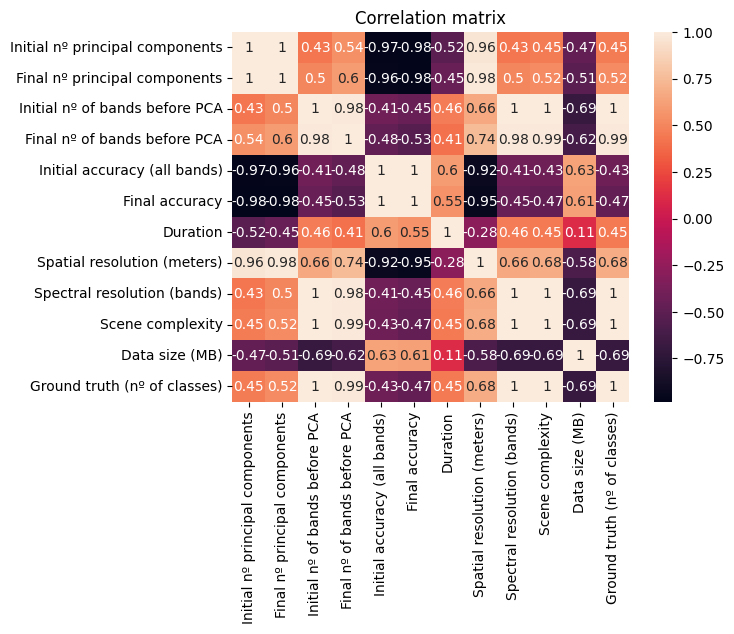

In [14]:
corr = df_combined.corr(numeric_only=False)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


# Components

In [15]:
df_pca


,Initial nº principal components,Final nº principal components
Salinas,6,6
Indian Pines,69,64
Pavia Centre,14,9
Pavia University,16,11


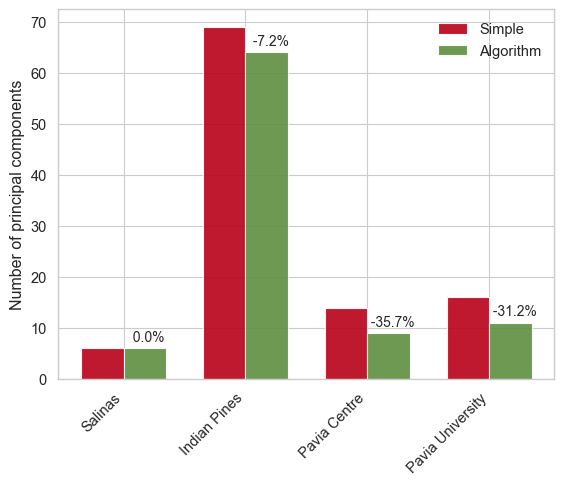

In [16]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)

width = 0.35

x = np.arange(len(df_pca.index))

fig, ax = plt.subplots()

bar1 = ax.bar(x - width/2, df_pca['Initial nº principal components'], width, label='Simple', alpha=0.9, color='#B80018')
bar2 = ax.bar(x + width/2, df_pca['Final nº principal components'], width, label='Algorithm', alpha=0.9, color='#5D8E3F')

ax.set_ylabel('Number of principal components')
#ax.set_title('Component reduction using our algorithm compared to simple PCA')
ax.set_xticks(x)
ax.set_xticklabels(df_pca.index, rotation=45, ha='right')
ax.legend(frameon=False)

# Add percentage difference at the top of each pair of bars
for i, (b1, b2) in enumerate(zip(bar1, bar2)):
    diff = ((b2.get_height() - b1.get_height()) / b1.get_height()) * 100
    ax.annotate(f'  {diff:.1f}%', xy=(b2.get_x() + b2.get_width() / 2, b2.get_height()), 
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10)

plt.savefig('../data/processed_images/pca_results.png', dpi=300, bbox_inches='tight')
plt.show()


# Bands

In [17]:
df_bands

,Initial nº of bands before PCA,Final nº of bands before PCA
Salinas,224,182
Indian Pines,220,200
Pavia Centre,102,81
Pavia University,103,62


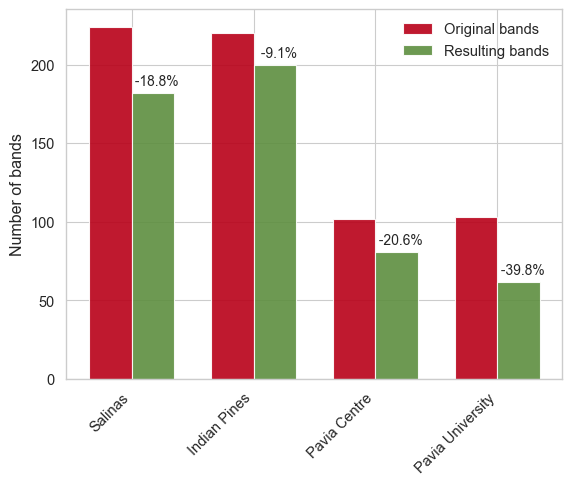

In [18]:
x = np.arange(len(df_bands.index))

fig, ax = plt.subplots()

bar1 = ax.bar(x - width/2, df_bands['Initial nº of bands before PCA'], width, alpha=0.9, label='Original bands', color='#B80018')
bar2 = ax.bar(x + width/2, df_bands['Final nº of bands before PCA'], width, alpha=0.9, label='Resulting bands', color='#5D8E3F')

ax.set_ylabel('Number of bands')
#x.set_title('Band reduction performed by our algorithm')
ax.set_xticks(x)
ax.set_xticklabels(df_bands.index, rotation=45, ha='right')
ax.legend(frameon=False)

for i, (b1, b2) in enumerate(zip(bar1, bar2)):
    diff = ((b2.get_height() - b1.get_height()) / b1.get_height()) * 100
    ax.annotate(f'  {diff:.1f}%', xy=(b2.get_x() + b2.get_width() / 2, b2.get_height()), 
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10)

plt.savefig('../data/processed_images/band_reduction_results.png', dpi=300, bbox_inches='tight')
plt.show()


# Accuracy

In [19]:
df_acc


,Initial accuracy (all bands),Final accuracy
Salinas,0.889543,0.895174
Indian Pines,0.720710,0.729007
Pavia Centre,0.892378,0.898099
Pavia University,0.837373,0.856461


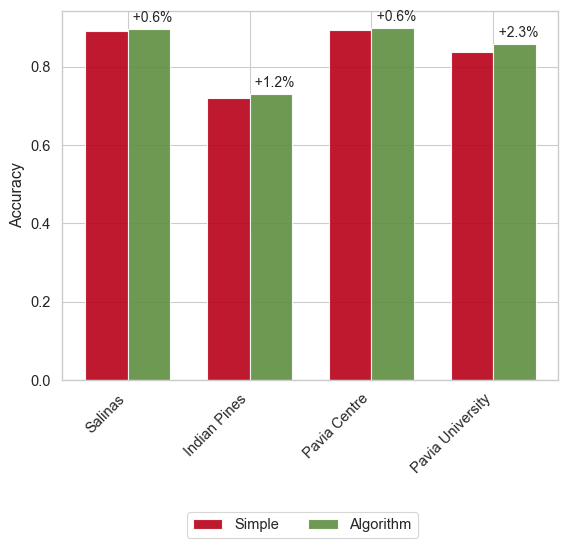

In [20]:
width = 0.35

x = np.arange(len(df_acc.index))

fig, ax = plt.subplots()

bar1 = ax.bar(x - width/2, df_acc['Initial accuracy (all bands)'], width, label='Simple', color='#B80018', alpha=0.9)
bar2 = ax.bar(x + width/2, df_acc['Final accuracy'], width, label='Algorithm', color='#5D8E3F', alpha=0.9)

ax.set_ylabel('Accuracy')
#ax.set_title('Accuracy improvement using our algorithm compared to simple PCA + XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(df_acc.index, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, bbox_transform=plt.gcf().transFigure)

for i, (b1, b2) in enumerate(zip(bar1, bar2)):
    diff = ((b2.get_height() - b1.get_height()) / b1.get_height()) * 100
    ax.annotate(f'  +{diff:.1f}%', xy=(b2.get_x() + b2.get_width() / 2, b2.get_height()), 
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10)

plt.savefig('../data/processed_images/accuracy_results.png', dpi=300, bbox_inches='tight')
plt.show()


# Times (not used)

In [21]:
df_times = df_combined[['Duration', 'Initial nº of bands before PCA', 'Final nº of bands before PCA']]

df_times


,Duration,Initial nº of bands before PCA,Final nº of bands before PCA
Dataset,,,
Salinas,4229.799,224,182
Indian Pines,1862.727,220,200
Pavia Centre,2727.677,102,81
Pavia University,1470.671,103,62


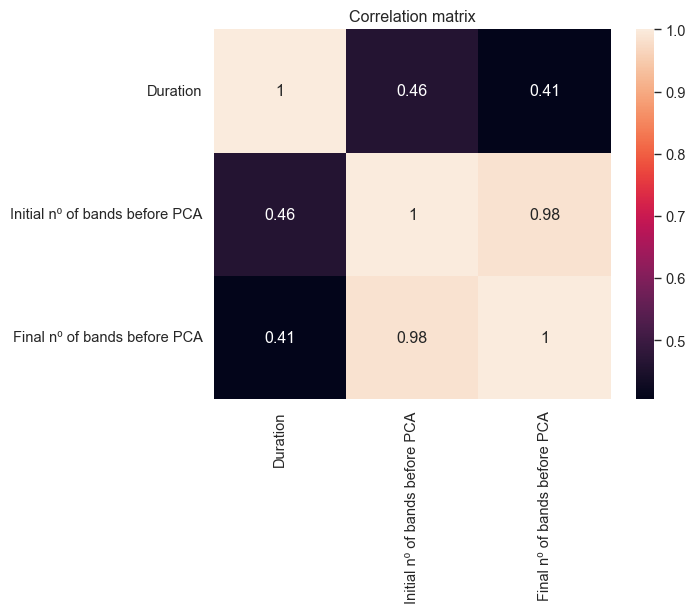

In [22]:
corr = df_times.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


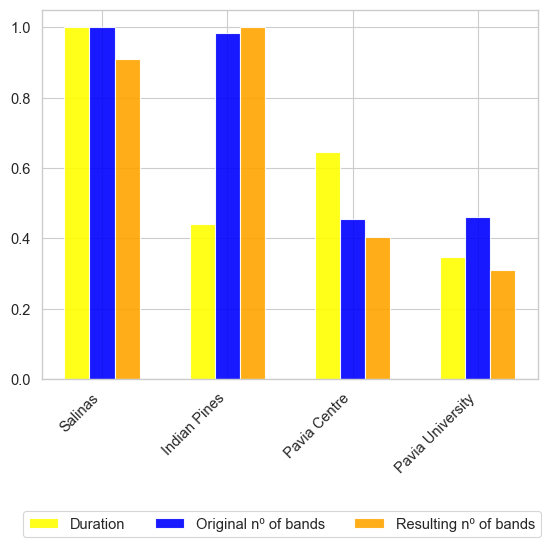

In [23]:
df_norm = df_times.copy()

for col in df_norm.columns:
    df_norm[col] = df_norm[col] / df_norm[col].max()

fig, ax = plt.subplots()

width = 0.2
x = np.arange(len(df_norm.index))

bar1 = ax.bar(x - width, df_norm['Duration'], width, label='Duration', color='yellow', alpha=0.9)
bar2 = ax.bar(x, df_norm['Initial nº of bands before PCA'], width, label='Original nº of bands', color='blue', alpha=0.9)
bar3 = ax.bar(x + width, df_norm['Final nº of bands before PCA'], width, label='Resulting nº of bands', color='orange', alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels(df_norm.index, rotation=45, ha='right')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, bbox_transform=plt.gcf().transFigure)

plt.savefig('../data/processed_images/time_results.png', dpi=300, bbox_inches='tight')

plt.show()


# Deleted bands

In [24]:
data_del = {'Deleted bands':[[147, 146, 221, 157, 102, 220, 36, 170, 38, 5, 134, 185, 154, 145, 107, 0, 125, 222, 211, 223, 204, 44, 175, 68, 162, 156, 177, 133, 158, 111, 63, 174, 219, 215, 150, 106, 164, 193, 109, 148, 206, 149],
            [192, 159, 12, 180, 103, 108, 122, 75, 165, 127, 109, 71, 124, 89, 30, 182, 67, 63, 173, 163],
            [1, 0, 2, 3, 8, 6, 4, 89, 92, 5, 38, 57, 42, 87, 81, 78, 9, 80, 75, 88, 26],
            [1, 0, 2, 3, 8, 4, 29, 52, 9, 49, 5, 57, 6, 43, 38, 73, 14, 26, 11, 102, 55, 22, 93, 94, 45, 98, 100, 80, 89, 46, 19, 18, 79, 51, 56, 50, 37, 59, 95, 36, 16]]
}

datasets_bands = ['Salinas (224 bands)', 'Indian Pines (220 bands)', 'Pavia Centre (102 bands)', 'Pavia University (103 bands)']

df_del = pd.DataFrame(data_del, index=datasets_bands)

df_del


,Deleted bands
Salinas (224 bands),"[147, 146, 221, 157, 102, 220, 36, 170, 38, 5,..."
Indian Pines (220 bands),"[192, 159, 12, 180, 103, 108, 122, 75, 165, 12..."
Pavia Centre (102 bands),"[1, 0, 2, 3, 8, 6, 4, 89, 92, 5, 38, 57, 42, 8..."
Pavia University (103 bands),"[1, 0, 2, 3, 8, 4, 29, 52, 9, 49, 5, 57, 6, 43..."


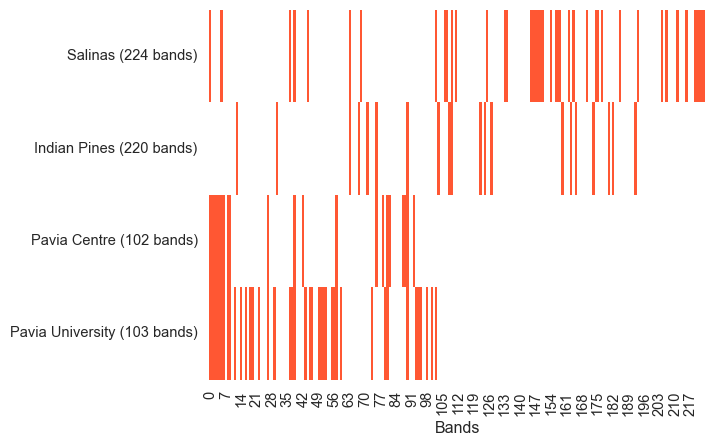

In [25]:
# Create a list of all possible bands
all_bands = np.arange(224)

# Create a numpy array with zeros
deleted_bands = np.zeros((len(df_del), len(all_bands)))

# Fill in the numpy array with 1 for deleted bands
for i, bands_list in enumerate(df_del['Deleted bands']):
    for band in bands_list:
        deleted_bands[i, band] = 1

# Create a dataframe with the deleted bands
df_deleted = pd.DataFrame(deleted_bands, columns=all_bands, index=df_del.index)

# Create a custom color palette for the heatmap
palette = sns.color_palette(['#FFFFFF', '#FF5733'])

# Create the heatmap
sns.heatmap(df_deleted, cmap=palette, cbar=False)

# Add labels and title
plt.xlabel('Bands')

plt.savefig('../data/processed_images/deleted_bands.png', dpi=300, bbox_inches='tight')

plt.show()


# Maps

In [26]:
#Preparing folder variables
main_folder = os.path.abspath(os.path.join(os.pardir))
data_folder = (main_folder + "/" +"data")

raw_data = (data_folder + "/" + "raw")

logs_folder = (data_folder + "/" + "logs")

saved_results_folder = (data_folder + "/" + "saved_results")

indian_pines_folder = (saved_results_folder + "/" + "indian_pines")
pavia_center_folder = (saved_results_folder + "/" + "pavia_center")
pavia_university_folder = (saved_results_folder + "/" + "pavia_university")
salinas_folder = (saved_results_folder + "/" + "salinas")


In [27]:
pavia_u = scipy.io.loadmat(raw_data + '/' + 'PaviaU.mat')['paviaU']
pavia_u_gt = scipy.io.loadmat(raw_data + "/" + "PaviaU_gt.mat")['paviaU_gt']

pavia_c = scipy.io.loadmat(raw_data + '/' + 'Pavia.mat')['pavia']
pavia_c_gt = scipy.io.loadmat(raw_data + "/" + "Pavia_gt.mat")['pavia_gt']

salinas = scipy.io.loadmat(raw_data + '/' + 'Salinas.mat')['salinas']
salinas_gt = scipy.io.loadmat(raw_data + '/' + 'Salinas_gt.mat')['salinas_gt']

indian_pines = scipy.io.loadmat(raw_data + '/' + 'Indian_pines.mat')['indian_pines']
indian_pines_gt = scipy.io.loadmat(raw_data + '/' + 'Indian_pines_gt.mat')['indian_pines_gt']


## Pavia University

In [28]:
n_samples = pavia_u.shape[0] * pavia_u.shape[1] 
n_bands = pavia_u.shape[2] 
hsi_image_reshaped = pavia_u.reshape(n_samples, n_bands) 

X_train, X_test, y_train, y_test = train_test_split(hsi_image_reshaped, pavia_u_gt.reshape(-1), stratify=pavia_u_gt.reshape(-1), test_size=0.9, random_state=42)


In [29]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)


[[    0 16462]
 [    1   663]
 [    2  1865]
 [    3   210]
 [    4   306]
 [    5   135]
 [    6   503]
 [    7   133]
 [    8   368]
 [    9    95]]


## Pavia Centre

In [30]:
n_samples = pavia_c.shape[0] * pavia_c.shape[1] 
n_bands = pavia_c.shape[2] 
hsi_image_reshaped = pavia_c.reshape(n_samples, n_bands) 

X_train, X_test, y_train, y_test = train_test_split(hsi_image_reshaped, pavia_c_gt.reshape(-1), stratify=pavia_c_gt.reshape(-1), test_size=0.9, random_state=42)


In [31]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)


[[    0 63549]
 [    1  6597]
 [    2   760]
 [    3   309]
 [    4   268]
 [    5   658]
 [    6   925]
 [    7   729]
 [    8  4283]
 [    9   286]]


## Salinas

In [32]:
n_samples = salinas.shape[0] * salinas.shape[1] 
n_bands = salinas.shape[2] 
hsi_image_reshaped = salinas.reshape(n_samples, n_bands) 

X_train, X_test, y_train, y_test = train_test_split(hsi_image_reshaped, salinas_gt.reshape(-1), stratify=salinas_gt.reshape(-1), test_size=0.9, random_state=42)


In [33]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)


[[   0 5697]
 [   1  201]
 [   2  372]
 [   3  197]
 [   4  139]
 [   5  268]
 [   6  396]
 [   7  358]
 [   8 1127]
 [   9  620]
 [  10  328]
 [  11  107]
 [  12  193]
 [  13   92]
 [  14  107]
 [  15  727]
 [  16  181]]


## Indian Pines

In [34]:
n_samples = indian_pines.shape[0] * indian_pines.shape[1] 
n_bands = indian_pines.shape[2] 
hsi_image_reshaped = indian_pines.reshape(n_samples, n_bands) 

X_train, X_test, y_train, y_test = train_test_split(hsi_image_reshaped, indian_pines_gt.reshape(-1), stratify=indian_pines_gt.reshape(-1), test_size=0.9, random_state=42)


In [35]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)


[[   0 1077]
 [   1    5]
 [   2  143]
 [   3   83]
 [   4   24]
 [   5   48]
 [   6   73]
 [   7    3]
 [   8   48]
 [   9    2]
 [  10   97]
 [  11  245]
 [  12   59]
 [  13   21]
 [  14  126]
 [  15   39]
 [  16    9]]
